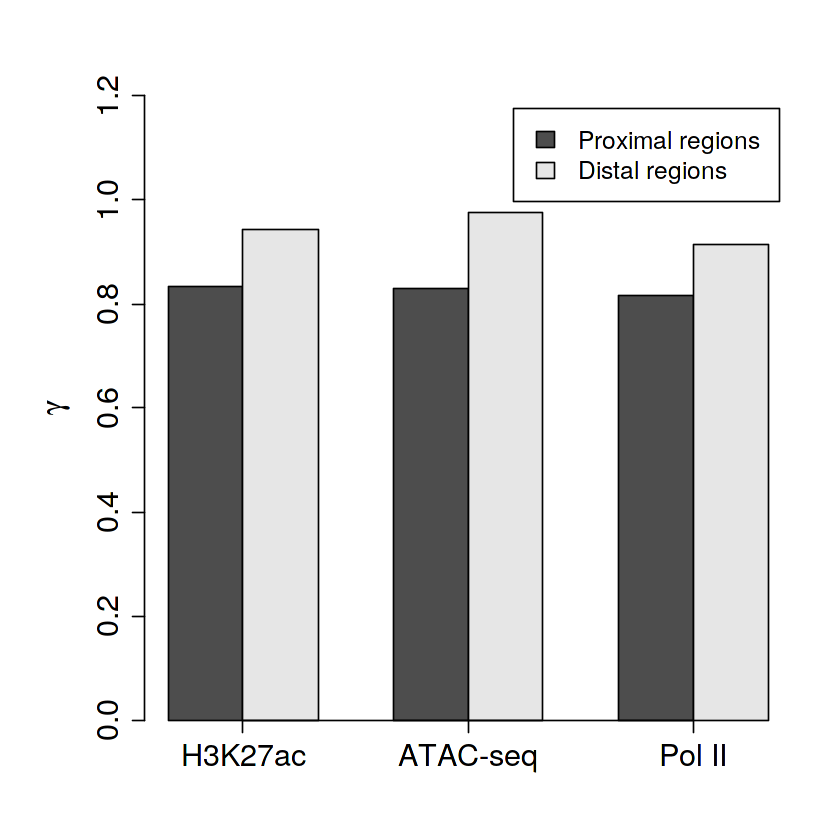

In [1]:
par(mar=c(5,6,4,2),cex.main=1,font.main=1)

m<-matrix(c(0.8335599,0.9429874,0.8292253,0.9766662,0.8173006,0.9146341),2,3)
barplot(m,beside=T,ylim=c(0,1.2),ylab=expression(italic(gamma)),cex.lab=1.5,cex.axis=1.5,
        legend=c('Proximal regions','Distal regions'),args.legend=c(cex=1.2))
axis(side=1,at=c(2,5,8),labels=c('H3K27ac','ATAC-seq','Pol II'),cex.axis=1.5)

In [ ]:
# Utility tools for calling hypervariable peaks.
library(MAnorm2)


# Compare the global variability of proximal and distal intervals.
cmp_proximal_distal <- function(cond, anno, mean.quantile = 0.1,
                                method = "local", args.lp = list(nn = 1.0)) {
    
    proximal <- anno == "proximal"
    distal <- anno == "distal"
    
    # Fit MVC.
    cond$occupancy <- (proximal | distal) 
    cond <- fitMeanVarCurve(list(cond), method = method, occupy.only = TRUE,
                            args.lp = args.lp)[[1]]

    # Determine d0.
    #cond$occupancy <- (proximal | distal) & f.occupy
    # This cond shall be returned.
    #cond <- estimatePriorDfRobust(list(cond), occupy.only = TRUE)[[1]]
    d0 <- Inf

    # Make the comparison.
    temp.cond <- cond
    temp.cond$occupancy <- proximal 
    temp.cond <- setPriorDfRobust(list(temp.cond), d0, occupy.only = TRUE)[[1]]
    g1 <- temp.cond$fit.info$ratio.var
    temp.cond <- cond
    temp.cond$occupancy <- distal 
    temp.cond <- setPriorDfRobust(list(temp.cond), d0, occupy.only = TRUE)[[1]]
    g2 <- temp.cond$fit.info$ratio.var

    list(cond, c(proximal = g1, distal = g2, ratio = g2 / g1))
}

#Read data and perform analysis
perform_analysis<-function(path){
    raw_reads_count<-read.table(path,header=T,sep='\t')
    number.of.samples<-0
    for(i in colnames(raw_reads_count)){
        if(grepl('occupancy',i)){
            number.of.samples=number.of.samples+1
        }
    }

    reads_count<-c(6:(6+number.of.samples-1))
    occupancy<-c((6+number.of.samples):(6+number.of.samples*2-1))
    reads_count<-c(6:(6+number.of.samples-1))
    occupancy<-c((6+number.of.samples):(6+number.of.samples*2-1))
    normalized.data<-normalize(raw_reads_count,reads_count,occupancy,
                               baseline='pseudo-reference',offset=0.5)
    
    flag<-substr(colnames(normalized.data)[reads_count],1,27)
    reads_count_columns<-list()
    occupancy_columns<-list()
    for(i in unique(flag)){
        temp1=reads_count[flag==i]
        temp2=occupancy[flag==i]
        if(length(temp1)==1){
            reads_count_columns[[i]]=normalized.data[,temp1]
            occupancy_columns[[paste(i,'_occupancy',sep='')]]=normalized.data[,temp2]
        }else{
            reads_count_columns[[i]]=rowMeans(normalized.data[,temp1])
            occupancy_columns[[paste(i,'_occupancy',sep='')]]=apply(normalized.data[,temp2],1,function(x){if(any(x==1)){return(1)}else{return(0)}})
        }
        
    }

    combined.df<-as.data.frame(c(reads_count_columns,occupancy_columns))
    reads_count<-c(1:length(reads_count_columns))
    occupancy<-c(1:length(occupancy_columns))+length(occupancy_columns)
    
    biocond<-bioCond(combined.df[reads_count],
                     combined.df[occupancy],
                     occupy.num=1,name='Tumor')
    temp<-cmp_proximal_distal(biocond,raw_reads_count$annotation)
    return(temp[[2]])
}

In [ ]:
paths<-Sys.glob('/media/chenhaojie/Data/Hyper_variable_peaks/TCGA_ATAC_seq/*/*all_peaks.txt')
result<-list()
for(path in paths){
    cancer_type<-strsplit(path,'/')[[1]][7]
    print(cancer_type)
    temp<-perform_analysis(path)
    result<-append(result,list(c(cancer_type,temp)))
}

In [2]:
color.map<-data.frame(cancer.type=c('ACC','BLCA','BRCA','CESC','CHOL','COAD','ESCA','GBM','HNSC',
                                           'KIRC','KIRP','LGG','LIHC','LUAD','LUSC','MESO','PCPG','PRAD',
                                           'SKCM','STAD','TGCT','THCA','UCEC'),
                             color=c('salmon','red','orangered','chocolate','darkorange','gold',
                                     'yellowgreen','darkgreen','turquoise','cyan','deepskyblue','blue',
                                     'slateblue','violet','darkviolet','saddlebrown','orange','deepskyblue',
                                     'plum','midnightblue','slategrey','navy','deeppink'))

In [12]:
gammas<-c('ACC','proximal',0.66573038196646,'distal',0.95481340531804,
'BLCA','proximal',0.644790766114402,'distal',1.02673005978312,
'BRCA','proximal',0.654202930538075,'distal',0.964096509832196,
'CESC','proximal',0.720798481724092,'distal',1.18597470451667,
'CHOL','proximal',0.723065633883575,'distal',1.08473824514018,
'COAD','proximal',0.576202744986081,'distal',0.942244210191426,
'ESCA','proximal',0.670625959639762,'distal',0.976851119885446,
'GBM','proximal',0.640727259082146,'distal',0.99305982345976,
'HNSC','proximal',0.776818758647701,'distal',1.02526314740195,
'KIRC','proximal',0.612613627700943,'distal',0.927119646074619,
'KIRP','proximal',0.63563918887798,'distal',0.900140180840632,
'LGG','proximal',0.729863682993136,'distal',0.963495945073068,
'LIHC','proximal',0.675873412952599,'distal',0.946463714002175,
'LUAD','proximal',0.667916772484256,'distal',0.98402568017713,
'LUSC','proximal',0.601552827934633,'distal',0.936762595625223,
'MESO','proximal',0.701720321795795,'distal',1.02250368882032,
'PCPG','proximal',0.618317663149296,'distal',1.02750234374408,
'PRAD','proximal',0.631464735682904,'distal',0.977116393520679,
'SKCM','proximal',0.539471743495851,'distal',0.988049174832318,
'STAD','proximal',0.621149472307372,'distal',0.968439480114351,
'TGCT','proximal',0.654843140630931,'distal',0.948302216192145,
'THCA','proximal',0.493239972506533,'distal',0.888038548972525,
'UCEC','proximal',0.829921341580533,'distal',0.955052298178959)
result<-t(matrix(gammas,ncol=23,nrow=5))
result

ACC,proximal,0.66573038196646,distal,0.95481340531804
BLCA,proximal,0.644790766114402,distal,1.02673005978312
BRCA,proximal,0.654202930538075,distal,0.964096509832196
CESC,proximal,0.720798481724092,distal,1.18597470451667
CHOL,proximal,0.723065633883575,distal,1.08473824514018
COAD,proximal,0.576202744986081,distal,0.942244210191426
ESCA,proximal,0.670625959639762,distal,0.976851119885446
GBM,proximal,0.640727259082146,distal,0.99305982345976
HNSC,proximal,0.776818758647701,distal,1.02526314740195
KIRC,proximal,0.612613627700943,distal,0.927119646074619
KIRP,proximal,0.63563918887798,distal,0.900140180840632


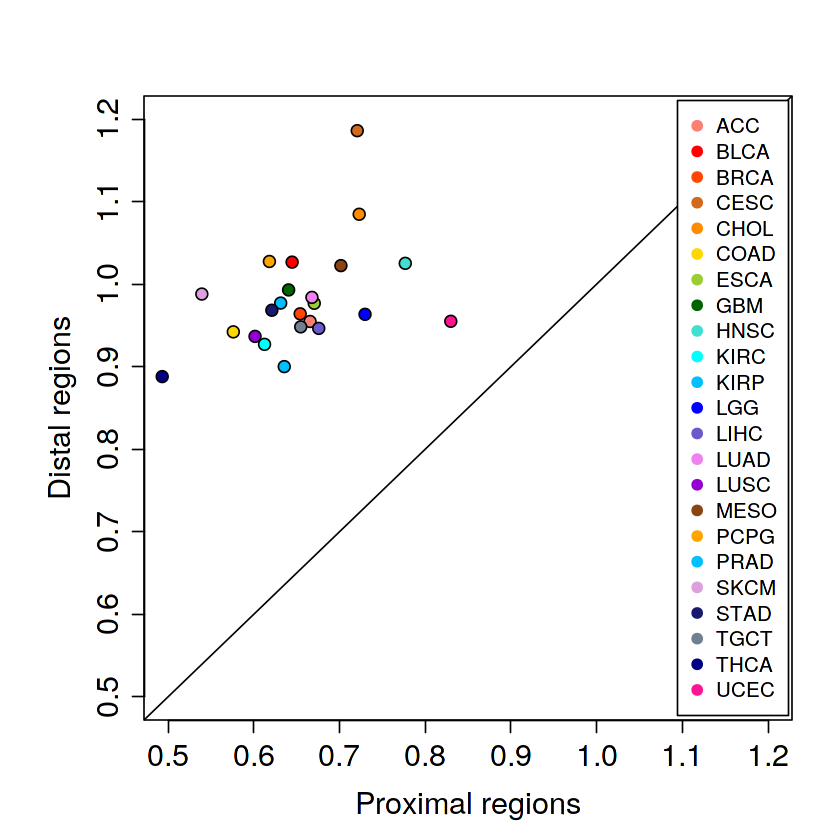

In [30]:
library(extrafont)

par(mar=c(5,6,4,2),cex.main=1,font.main=1)

plot(c(0),c(0),
    xlim=c(0.5,1.2),ylim=c(0.5,1.2),xlab='Proximal regions',ylab='Distal regions',
    col='white',
    pch=c(19),
    #main='Variance ratio(Gamma)',
    cex.lab=1.5,cex.axis=1.5,cex.main=1.5
)
for(i in c(1:dim(result)[1])){
    col<-as.character(color.map[color.map['cancer.type']==result[i,1],'color'])
    points(result[i,3],result[i,5],
           col='black',
           bg=col,
           pch=c(21),cex=1.2)
}

lines(c(0,2),c(0,2))
legend(1.095,1.223,as.character(color.map$cancer.type),
       inset=0.0025,
       pch=c(19),
       col=as.character(color.map$color))
